In [83]:
import requests
import pandas as pd
import time
import os
import sys
import json

In [52]:
# Add the path to your ML/ folder (project root)
project_root = os.path.abspath("..")  # or use "../../" if you're nested deeper
if project_root not in sys.path:
    sys.path.append(project_root)

In [53]:
%load_ext autoreload
%autoreload 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
%autoreload 0

***Load June 13th Roster Update Data***

In [84]:
from prediction_model.data_loader import load_roster_update_data
update_df = load_roster_update_data(11)
update_df.count()

player_name      631
player_id        631
old_overall      631
new_overall      631
upgrade_label    631
dtype: int64

In [85]:
update_df.head(20)

,player_name,player_id,old_overall,new_overall,upgrade_label
0,José Ramírez,9f7525e81c88f596b6b62c68427d4df7,91,92,1
1,Tarik Skubal,b2585f509345e30749a913d76f462bc3,89,91,1
2,Ketel Marte,8b04eba77f2245a80433843a3b8264a4,89,91,1
3,Shohei Ohtani,2ad8d7208c18f493011f8cf0426d0fad,91,91,0
4,Bobby Witt Jr.,39bd515b8dce9d0de8565f8f6bc0463a,91,91,0
5,Fernando Tatis Jr.,514cce4a132d7b9e56401205f68d9c04,92,90,0
6,Pete Crow-Armstrong,8234cce56c28676c57fe7edfd27ead32,87,90,1
7,Cal Raleigh,5a58eebb09702f888abeccdba79546a6,86,89,1
8,Paul Skenes,1c5d43a0f69492a369dba76354a3fe52,88,89,1
9,Francisco Lindor,47cd0dad82d80e6545d96c0fe0fe8da1,89,89,0


***Load pre June 13th Player Attribute Data (Only players that were in the May 23rd roster update)***

In [86]:
from prediction_model.data_loader import load_player_attributes
uuids = update_df["player_id"].tolist()
attribute_df = load_player_attributes(uuids, 'pre-ru-6-13')
attribute_df.head(10)

[Cache hit] 9f7525e81c88f596b6b62c68427d4df7
[Cache hit] b2585f509345e30749a913d76f462bc3
[Cache hit] 8b04eba77f2245a80433843a3b8264a4
[Cache hit] 2ad8d7208c18f493011f8cf0426d0fad
[Cache hit] 39bd515b8dce9d0de8565f8f6bc0463a
[Cache hit] 514cce4a132d7b9e56401205f68d9c04
[Cache hit] 8234cce56c28676c57fe7edfd27ead32
[Cache hit] 5a58eebb09702f888abeccdba79546a6
[Cache hit] 1c5d43a0f69492a369dba76354a3fe52
[Cache hit] 47cd0dad82d80e6545d96c0fe0fe8da1
[Cache hit] b6c47a7beb6a9d82dd6149b6643935e4
[Cache hit] f99d32d586c4b1d5e120e25770fe5238
[Cache hit] 20c361dae26c548a297c7bd43b5f6ffa
[Cache hit] 713475f9556677741ad2cf55e62d6f6e
[Cache hit] 6201006ca73bfb4966550c5228932da6
[Cache hit] 4dfd1d3eb70a47d3611a8bc08fdc155d
[Cache hit] bbcb0a179f5728cd615974a511d38bd4
[Cache hit] 0598165d8f7d7e39e209a26fe86d8d6a
[Cache hit] 3acb546257bdab68f5cef5ea5fb15785
[Cache hit] ef09d35efd8dcac068723cec8ee2b9b2
[Cache hit] b1a47a251e71206f1308be13a3cdf43d
[Cache hit] 639c83a3e92c8214eb47a462844527f8
[Cache hit

,player_name,player_id,overall_rating,is_hitter,contact_left,contact_right,power_left,power_right,vision,discipline,hits_per_9,k_per_9,bb_per_9,hr_per_9
0,José Ramírez,9f7525e81c88f596b6b62c68427d4df7,92,True,115,88,72,81,97,65,0,0,0,0
1,Tarik Skubal,b2585f509345e30749a913d76f462bc3,91,False,0,0,0,0,0,0,81,77,95,79
2,Ketel Marte,8b04eba77f2245a80433843a3b8264a4,91,True,89,85,79,92,83,90,0,0,0,0
3,Shohei Ohtani,2ad8d7208c18f493011f8cf0426d0fad,91,False,83,90,86,112,60,90,94,88,50,98
4,Bobby Witt Jr.,39bd515b8dce9d0de8565f8f6bc0463a,91,True,99,82,40,62,80,59,0,0,0,0
5,Fernando Tatis Jr.,514cce4a132d7b9e56401205f68d9c04,90,True,55,86,56,90,75,70,0,0,0,0
6,Pete Crow-Armstrong,8234cce56c28676c57fe7edfd27ead32,90,True,42,83,52,78,57,38,0,0,0,0
7,Cal Raleigh,5a58eebb09702f888abeccdba79546a6,89,True,100,95,115,113,57,94,0,0,0,0
8,Paul Skenes,1c5d43a0f69492a369dba76354a3fe52,89,False,34,36,26,22,25,25,95,69,79,83
9,Francisco Lindor,47cd0dad82d80e6545d96c0fe0fe8da1,89,True,73,80,89,75,77,58,0,0,0,0


***Split Attribute Data and Roster Update Data into Hitters and Pitchers***

In [87]:
from prediction_model.preprocess import split_attribute_data, merge_and_split_roster_update
hitter_attribute_data, pitcher_attribute_data = split_attribute_data(attribute_df)
hitter_ru_data, pitcher_ru_data = merge_and_split_roster_update(update_df, attribute_df)

***Merge Attribute and Roster Update Data***

In [88]:
from prediction_model.preprocess import merge_attribute_roster
hitter_df = merge_attribute_roster(hitter_attribute_data, hitter_ru_data)
pitcher_df = merge_attribute_roster(pitcher_attribute_data, pitcher_ru_data)
hitter_df.count()

player_name       322
player_id         322
overall_rating    322
is_hitter         322
contact_left      322
contact_right     322
power_left        322
power_right       322
vision            322
discipline        322
old_overall       322
new_overall       322
upgrade_label     322
dtype: int64

***Import and Merge Fangraph Data (LHP and RHP)***

In [89]:
from prediction_model.preprocess import merge_lhp_rhp

merged = merge_lhp_rhp(r"C:\Users\mgams\Projects\mlb-market-app\ML\data\irl_data\Hitters\Advanced\fg_5-24_6-10_LHP.csv", r"C:\Users\mgams\Projects\mlb-market-app\ML\data\irl_data\Hitters\Advanced\fg_5-24_6-10_RHP.csv")
merged.head()

,playerId,Name,lhp_BB%,lhp_K%,lhp_AVG,lhp_OBP,lhp_SLG,rhp_BB%,rhp_K%,rhp_AVG,rhp_OBP,rhp_SLG
0,15640,Aaron Judge,0.217391,0.260870,0.333333,0.478261,0.722222,0.159091,0.250000,0.416667,0.522727,0.916667
1,19844,Abraham Toro,0.055556,0.111111,0.312500,0.333333,0.375000,0.041667,0.145833,0.377778,0.416667,0.688889
2,15223,Adam Frazier,NaN,NaN,NaN,NaN,NaN,0.023810,0.190476,0.358974,0.404762,0.512821
3,24598,Addison Barger,0.153846,0.230769,0.272727,0.384615,0.272727,0.037736,0.264151,0.274510,0.301887,0.647059
4,26288,Adley Rutschman,0.222222,0.111111,0.214286,0.388889,0.214286,0.108108,0.216216,0.281250,0.351351,0.500000


***Merge Attribute, RU, and FG Data***

In [90]:
from prediction_model.preprocess import merge_fangraphs_data, normalize_name
fully_merged_df = merge_fangraphs_data(hitter_df, merged)

[merge_fangraphs_data] Total players: 324 | Matched: 311 | Unmatched: 13
Unmatched player names: ['Luis García' 'Josh H. Smith' 'Joseph Ortiz' 'Tyler Heineman'
 'Garrett Hampson' 'Josh Palacios' 'Christian Encarnacion' 'Nick Kurtz'
 'Quincy McAfee' 'Dominic Canzone' 'Brett Sullivan' 'Jared Serna'
 'Brendan Rodgers']


***Inspect Final DataFrame***

🧾 Shape of DataFrame: (324, 24)
🧯 Missing Values:
lhp_BB%     116
lhp_K%      116
lhp_AVG     116
lhp_SLG     116
lhp_OBP     116
rhp_K%       21
rhp_BB%      21
rhp_OBP      21
rhp_AVG      21
rhp_SLG      21
playerId     13
dtype: int64
🔁 Duplicate player IDs: 2
🔁 Duplicate player names: 3
✅ Dropped duplicates — 2 rows removed (based on player_id)
📊 Summary statistics (numerical columns):
                count          mean          std        min           25%  \
overall_rating  322.0     75.987578     6.034674    60.0000     72.000000   
contact_left    322.0     62.962733    18.562814    25.0000     48.000000   
contact_right   322.0     64.403727    15.528239    29.0000     53.000000   
power_left      322.0     53.897516    18.157464    25.0000     40.000000   
power_right     322.0     57.916149    16.802568    29.0000     45.000000   
vision          322.0     66.770186    14.894959    30.0000     57.000000   
discipline      322.0     60.043478    18.078006    23.0000     46.

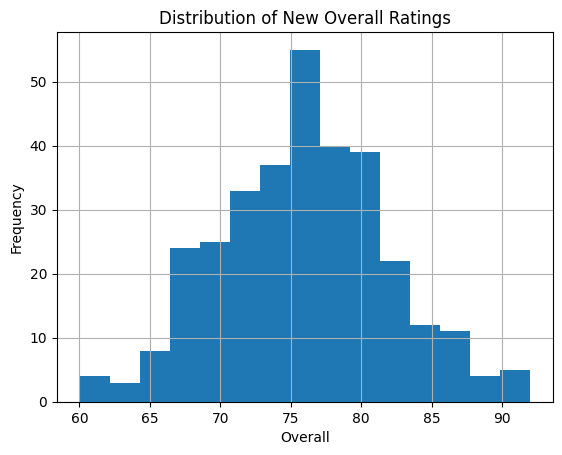

🔎 Sample of 5 random rows:
          player_name                         player_id  overall_rating  \
174    Hunter Goodman  07c6e859804bc7c99c9f2ba6c2279291              75   
133      Ryan Jeffers  412d8041678afb7c55231d1557de1963              78   
198  Mike Yastrzemski  a9caa33b9949fe22ffc9710ae28bab8d              74   
9        Bryce Harper  6201006ca73bfb4966550c5228932da6              87   
105       José Altuve  7bb4572064cdccafa891089ea5ac1add              79   

     is_hitter  contact_left  contact_right  power_left  power_right  vision  \
174       True            59             74          73           62      59   
133       True            62             69          69           54      74   
198       True            46             67          44           63      67   
9         True            82             70          77           74      75   
105       True            93             75          60           58      83   

     discipline  ...   lhp_BB%    lhp_K% 

In [91]:
from prediction_model.utility import inspect_dataframe
clean_final = inspect_dataframe(fully_merged_df, drop_duplicates=True)


***Drop players that don't have FanGraphs Data***

In [92]:
fg_cols = [col for col in clean_final.columns if col.startswith("lhp_") or col.startswith("rhp_")]
before = clean_final.shape[0]

clean_final = clean_final[~clean_final[fg_cols].isnull().all(axis=1)].copy()

after = clean_final.shape[0]
print(f"Dropped {before - after} players with no FanGraphs stats. Final row count: {after}")


Dropped 13 players with no FanGraphs stats. Final row count: 309


In [93]:
import importlib
import prediction_model.utility
importlib.reload(prediction_model.utility)

from prediction_model.utility import add_missing_indicators
df = add_missing_indicators(clean_final, "lhp_")
df = add_missing_indicators(df, "rhp_")
df = df.drop(columns=[col for col in df.columns if col.endswith("_missing") and (col.startswith("lhp_") or col.startswith("rhp_"))])
print([col for col in df.columns if "missing" in col])
df.head(10)

Columns used for 'lhp_': ['lhp_BB%', 'lhp_K%', 'lhp_AVG', 'lhp_OBP', 'lhp_SLG']
Columns used for 'rhp_': ['rhp_BB%', 'rhp_K%', 'rhp_AVG', 'rhp_OBP', 'rhp_SLG']
['missing_lhp_stats', 'missing_rhp_stats']


,player_name,player_id,overall_rating,is_hitter,contact_left,contact_right,power_left,power_right,vision,discipline,...,lhp_AVG,lhp_OBP,lhp_SLG,rhp_BB%,rhp_K%,rhp_AVG,rhp_OBP,rhp_SLG,missing_lhp_stats,missing_rhp_stats
0,José Ramírez,9f7525e81c88f596b6b62c68427d4df7,92,True,115,88,72,81,97,65,...,0.379310,0.400000,0.413793,0.157895,0.131579,0.437500,0.526316,0.812500,0,0
1,Ketel Marte,8b04eba77f2245a80433843a3b8264a4,91,True,89,85,79,92,83,90,...,0.277778,0.380952,0.500000,0.266667,0.155556,0.363636,0.533333,0.666667,0,0
2,Bobby Witt Jr.,39bd515b8dce9d0de8565f8f6bc0463a,91,True,99,82,40,62,80,59,...,0.300000,0.300000,0.300000,0.072727,0.272727,0.240000,0.290909,0.480000,0,0
3,Fernando Tatis Jr.,514cce4a132d7b9e56401205f68d9c04,90,True,55,86,56,90,75,70,...,0.166667,0.210526,0.222222,0.153846,0.134615,0.186047,0.326923,0.255814,0,0
4,Pete Crow-Armstrong,8234cce56c28676c57fe7edfd27ead32,90,True,42,83,52,78,57,38,...,0.086957,0.160000,0.086957,0.045455,0.227273,0.292683,0.318182,0.585366,0,0
5,Cal Raleigh,5a58eebb09702f888abeccdba79546a6,89,True,100,95,115,113,57,94,...,0.315789,0.350000,0.684211,0.127660,0.191489,0.268293,0.361702,0.780488,0,0
6,Francisco Lindor,47cd0dad82d80e6545d96c0fe0fe8da1,89,True,73,80,89,75,77,58,...,0.388889,0.450000,0.722222,0.063830,0.234043,0.261905,0.319149,0.452381,0,0
7,Freddie Freeman,b6c47a7beb6a9d82dd6149b6643935e4,89,True,85,112,67,73,76,74,...,0.166667,0.210526,0.277778,0.113208,0.169811,0.382979,0.452830,0.510638,0,0
8,Mookie Betts,20c361dae26c548a297c7bd43b5f6ffa,88,True,77,81,73,67,99,80,...,0.400000,0.470588,0.666667,0.097561,0.097561,0.270270,0.341463,0.297297,0,0
9,Bryce Harper,6201006ca73bfb4966550c5228932da6,87,True,82,70,77,74,75,97,...,NaN,NaN,NaN,0.117647,0.294118,0.214286,0.352941,0.428571,1,0


In [95]:
print(df.columns.tolist())

['player_name', 'player_id', 'overall_rating', 'is_hitter', 'contact_left', 'contact_right', 'power_left', 'power_right', 'vision', 'discipline', 'old_overall', 'new_overall', 'upgrade_label', 'playerId', 'lhp_BB%', 'lhp_K%', 'lhp_AVG', 'lhp_OBP', 'lhp_SLG', 'rhp_BB%', 'rhp_K%', 'rhp_AVG', 'rhp_OBP', 'rhp_SLG', 'missing_lhp_stats', 'missing_rhp_stats']


***EDA***

In [110]:
df.describe()

,overall_rating,contact_left,contact_right,power_left,power_right,vision,discipline,old_overall,new_overall,upgrade_label,...,lhp_AVG,lhp_OBP,lhp_SLG,rhp_BB%,rhp_K%,rhp_AVG,rhp_OBP,rhp_SLG,missing_lhp_stats,missing_rhp_stats
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,...,208.000000,208.000000,208.000000,301.000000,301.000000,301.000000,301.000000,301.000000,309.000000,309.000000
mean,76.255663,63.462783,64.750809,54.504854,58.307443,67.003236,60.411003,75.954693,76.255663,0.401294,...,0.242060,0.305902,0.387780,0.085660,0.216244,0.249111,0.319418,0.402861,0.326861,0.025890
std,5.927813,18.625742,15.550067,18.229351,16.769812,14.811477,18.187230,6.010101,5.927813,0.490955,...,0.114285,0.117041,0.222510,0.057124,0.095089,0.086036,0.091636,0.173982,0.469827,0.159065
min,60.000000,25.000000,29.000000,25.000000,29.000000,30.000000,23.000000,59.000000,60.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000
25%,72.000000,48.000000,54.000000,40.000000,46.000000,57.000000,46.000000,72.000000,72.000000,0.000000,...,0.166667,0.210526,0.228632,0.045455,0.145833,0.194444,0.260870,0.285714,0.000000,0.000000
50%,76.000000,61.000000,64.000000,52.000000,58.000000,67.000000,61.000000,76.000000,76.000000,0.000000,...,0.235294,0.303846,0.384615,0.076923,0.212121,0.250000,0.320000,0.387097,0.000000,0.000000
75%,81.000000,77.000000,75.000000,66.000000,69.000000,77.000000,72.000000,80.000000,81.000000,1.000000,...,0.321970,0.400000,0.505435,0.114286,0.274510,0.304348,0.377778,0.512195,1.000000,0.000000
max,92.000000,115.000000,112.000000,115.000000,113.000000,115.000000,115.000000,92.000000,92.000000,1.000000,...,0.526316,0.550000,1.400000,0.312500,0.533333,0.500000,0.576923,0.904762,1.000000,1.000000


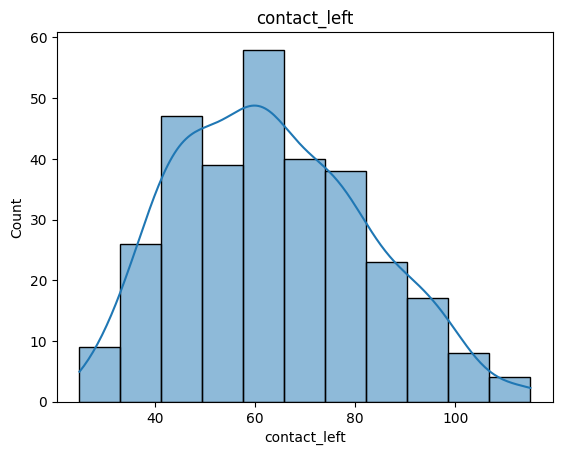

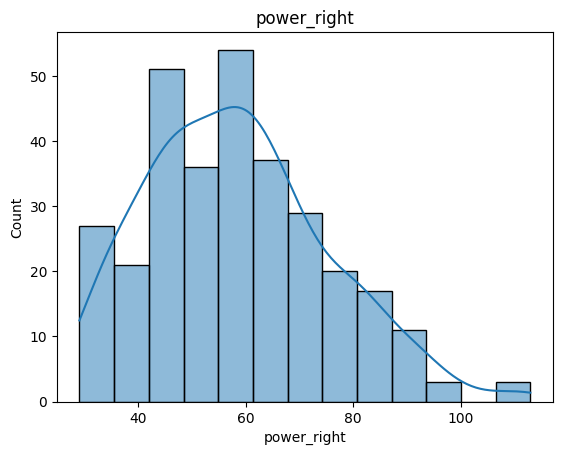

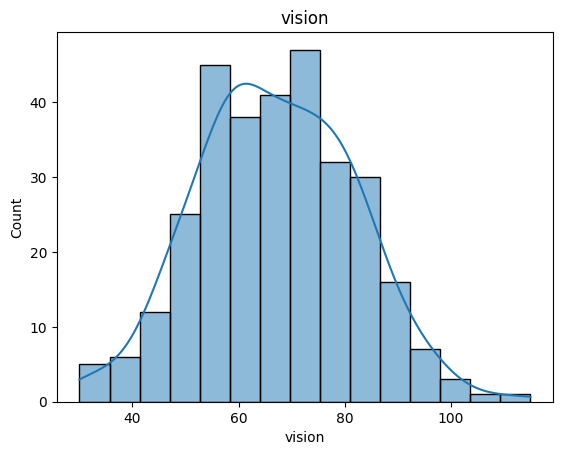

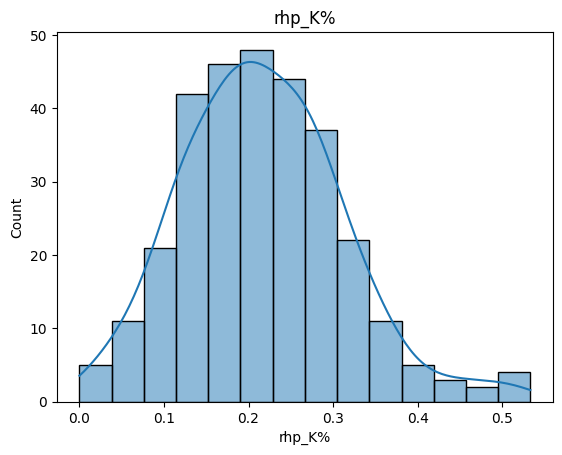

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in ['contact_left', 'power_right', 'vision', 'rhp_K%']:
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(col)
    plt.show()


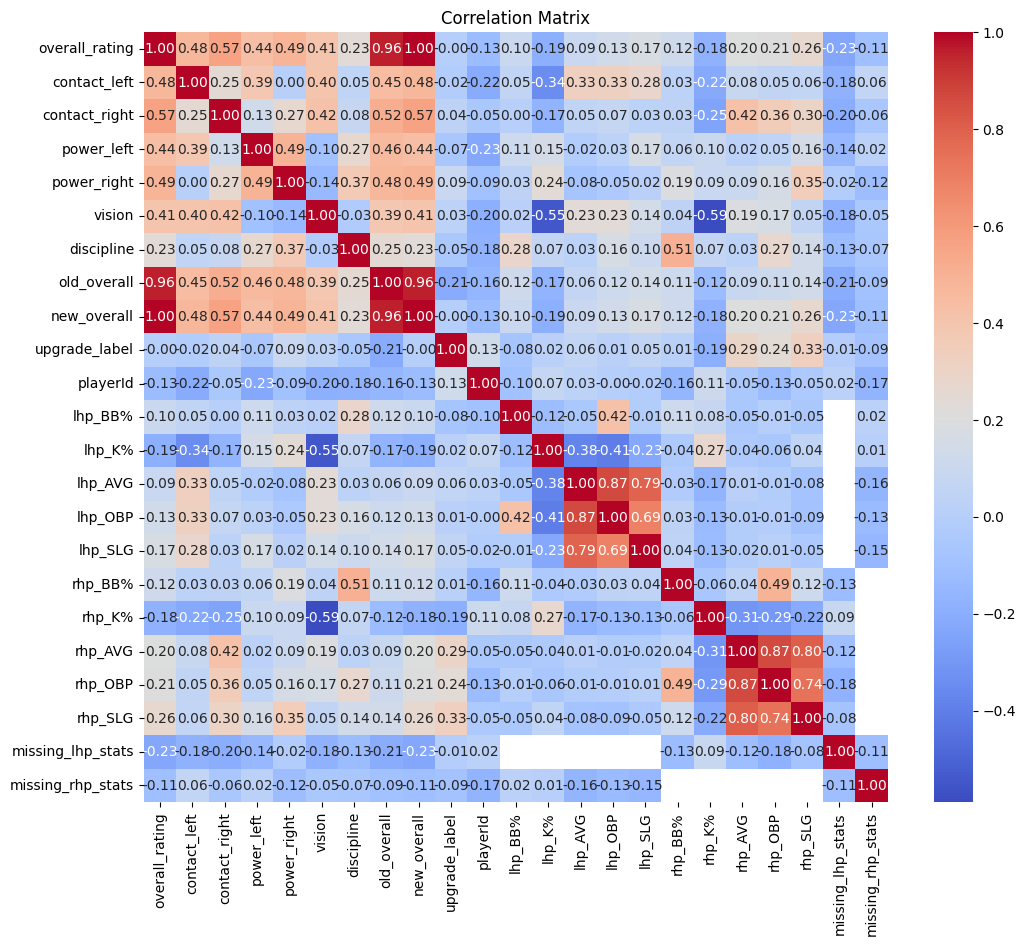

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = num_features.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [126]:
# Dropping OBP as it seems to be a redundant feature
df = df.drop(columns=[col for col in df.columns if col.endswith('_OBP')])
# Preview IRL stat columns left
irl_stats = [col for col in df.columns if col.startswith('lhp_') or col.startswith('rhp_')]
print("Remaining IRL stats:", irl_stats)

Remaining IRL stats: ['lhp_BB%', 'lhp_K%', 'lhp_AVG', 'lhp_SLG', 'rhp_BB%', 'rhp_K%', 'rhp_AVG', 'rhp_SLG']


In [125]:
df.isnull().sum()

player_name            0
player_id              0
overall_rating         0
is_hitter              0
contact_left           0
contact_right          0
power_left             0
power_right            0
vision                 0
discipline             0
old_overall            0
new_overall            0
upgrade_label          0
playerId               0
lhp_BB%              101
lhp_K%               101
lhp_AVG              101
lhp_SLG              101
rhp_BB%                8
rhp_K%                 8
rhp_AVG                8
rhp_SLG                8
missing_lhp_stats      0
missing_rhp_stats      0
dtype: int64

***Model Training***

In [ ]:
import importlib
import prediction_model.tracking
import prediction_model.model
importlib.reload(prediction_model.tracking)
importlib.reload(prediction_model.model)

from prediction_model.model import train_model


model, X_train, X_test, y_train, y_test, y_pred = train_model(
    df = df,
    target = "upgrade_label",
    model_name = "XGBoost_v2_cleaned",
    notes = r"Baseline run, raw attributes + FG stats, no scaling or feature engineering. Dropped OBP as BB% and Avg is enough to capture OBP"
)

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        37
           1       0.60      0.60      0.60        25

    accuracy                           0.68        62
   macro avg       0.66      0.66      0.66        62
weighted avg       0.68      0.68      0.68        62

✅ Accuracy: 0.6774
✅ Weighted F1 Score: 0.6774
💾 Model saved to saved_models\XGBoost_v1_dropped_is_hitter_and_new_overall.joblib


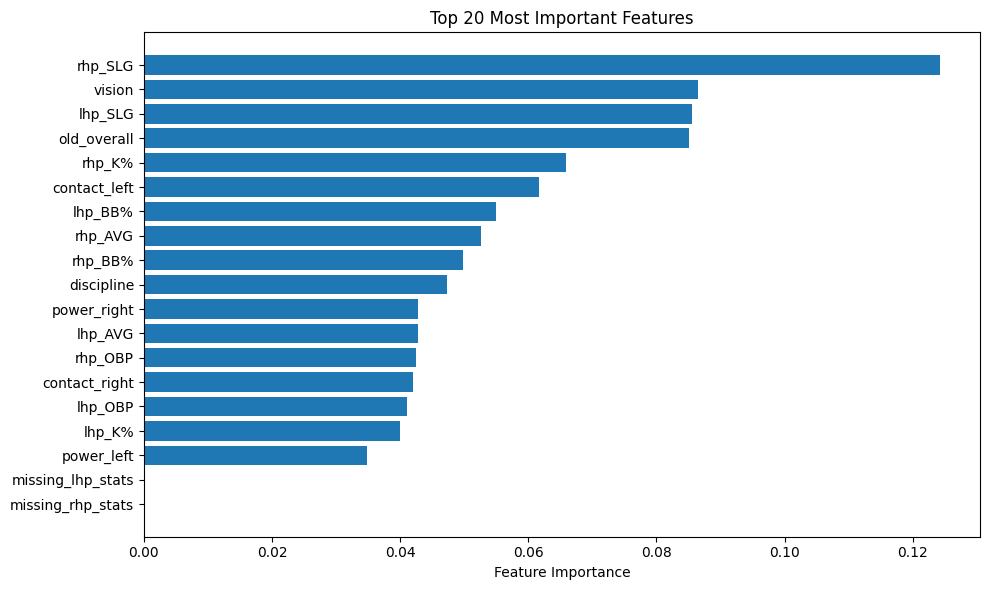

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importances
importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easy sorting and plotting
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Show top 20 features
importance_df.head(20)


plt.figure(figsize=(10, 6))
plt.barh(importance_df["feature"][:20][::-1], importance_df["importance"][:20][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features")
plt.tight_layout()
plt.show()

importance_df.to_csv("../prediction_model/feature_sets/XGBoost_v1_raw_features_importance.csv", index=False)



Training Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [ ]:
# Select input features
feature_cols = ["AVG", "OBP", "SLG", "HR"]  # you can expand this later
X = training_df[feature_cols]
y = training_df["upgrade_label"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a basic model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Performance evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

importances = clf.feature_importances_
plt.barh(feature_cols, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest: IRL Stats vs. SDS Upgrades")
plt.show()